In [1]:
import os
import sys

sys.path.append("../../../")

import json
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from povertymapping import dhs, feature_engineering, iso3, nightlights, settings

%reload_ext autoreload
%autoreload 2

## Set Parameters

In [2]:
# These configure some params for the feature engineering steps.
COUNTRY_CODE = "mm"
COUNTRY_OSM = "myanmar"
OOKLA_YEAR = 2019
NIGHTLIGHTS_YEAR = 2015

# You need to download these datasets from the DHS website before running this notebook.
DHS_HOUSEHOLD_DTA_PATH = Path(settings.DATA_DIR / "dhs/mm/MMHR71DT/MMHR71FL.DTA")
DHS_GEOGRAPHIC_SHP_PATH = Path(settings.DATA_DIR / "dhs/mm/MMGE71FL/MMGE71FL.shp")

# Indicate name of column from dhs data that will be used as the label for training
DHS_LABEL_COL = "Wealth Index"
OUTPUT_LABEL_COL = "Wealth Index - Scaled"

# Tile size for the area around a DHS household cluster to generate features for.
# We set this to 2.4km to match target rollout size of Bing Tile Zoom Level 14 (~2.4km)
TILE_SIZE_KM = 2.4

# For convenience, consider the rollout version as the date of the root notebook folder.
ROLLOUT_DATE = "-".join(os.getcwd().split("/")[-2].split("-")[:3])

## Set up EOG API Access
The following cell will prompt you to enter your EOG username and password. See [this page](https://eogdata.mines.edu/products/register/) to learn how to set-up your EOG account.

In [3]:
# Log-in using EOG credentials
username = os.environ.get("EOG_USER", None)
username = username if username is not None else input("Username?")
password = os.environ.get("EOG_PASSWORD", None)
password = password if password is not None else getpass.getpass("Password?")

# set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token
access_token = nightlights.get_eog_access_token(username, password, save_token=True)

2023-04-24 13:19:49.780 | INFO     | povertymapping.nightlights:get_eog_access_token:42 - Saving access_token to /home/alron/.eog_creds/eog_access_token.txt
2023-04-24 13:19:49.781 | INFO     | povertymapping.nightlights:get_eog_access_token:50 - Adding access token to environment var EOG_ACCESS_TOKEN


## Load DHS Data

In [4]:
dhs_gdf = dhs.generate_dhs_cluster_level_data(
    DHS_HOUSEHOLD_DTA_PATH,
    DHS_GEOGRAPHIC_SHP_PATH,
    col_rename_config=COUNTRY_CODE,
    convert_geoms_to_bbox=True,
    bbox_size_km=TILE_SIZE_KM,
).reset_index(drop=True)

In [5]:
# Uncomment to view interactive map
# dhs_gdf.explore()

In [6]:
# Inspect the generated data
dhs_gdf.head(3)

,DHSCLUST,Wealth Index,DHSID,DHSCC,DHSYEAR,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,...,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,ALT_GPS,ALT_DEM,DATUM,geometry
0,1,-52232.000000,MM201500000001,MM,2015.0,BM,NULL,NULL,NULL,NULL,...,8.0,Magway,GPS,R,20.058637,95.360081,107.0,105.0,WGS84,"POLYGON ((95.34859 20.06943, 95.37157 20.06943..."
1,2,130773.724138,MM201500000002,MM,2015.0,BM,NULL,NULL,NULL,NULL,...,12.0,Yangon,GPS,U,17.112398,96.045616,31.0,14.0,WGS84,"POLYGON ((96.03432 17.12319, 96.05691 17.12319..."
2,3,-4955.000000,MM201500000003,MM,2015.0,BM,NULL,NULL,NULL,NULL,...,10.0,Mon,GPS,R,16.507664,97.364236,4.0,2.0,WGS84,"POLYGON ((97.35298 16.51846, 97.37549 16.51846..."


## Feature Engineering and Label Pre-processing

If this is your first time running this notebook for this specific country, expect a long runtime for the following cell as it will download and cache the required datasets. It will then process the relevant features for each area specified. On subsequent runs, the runtime will be much faster as the data is already stored in your filesystem. 

In [7]:
%%time
scaler = MinMaxScaler
country_data = dhs_gdf.copy()

# Create labels dataframe by scaling the specified dhs_label_col (ex. Wealth Index)
labels = scaler().fit_transform(country_data[[DHS_LABEL_COL]])
labels = pd.DataFrame(labels, columns=[OUTPUT_LABEL_COL])

# Create features dataframe using generate_features module
features = feature_engineering.generate_features(
    country_data,
    country_osm=COUNTRY_OSM,
    ookla_year=OOKLA_YEAR,
    nightlights_year=NIGHTLIGHTS_YEAR,
    scale=False,
    features_only=True,
)

2023-04-24 13:19:53.858 | INFO     | povertymapping.osm:download_osm_country_data:198 - OSM Data: Cached data available for myanmar at /home/alron/.geowrangler/osm/myanmar? True
2023-04-24 13:19:53.859 | DEBUG    | povertymapping.osm:load_pois:160 - OSM POIs for myanmar being loaded from /home/alron/.geowrangler/osm/myanmar/gis_osm_pois_free_1.shp
2023-04-24 13:19:56.901 | INFO     | povertymapping.osm:download_osm_country_data:198 - OSM Data: Cached data available for myanmar at /home/alron/.geowrangler/osm/myanmar? True
2023-04-24 13:19:56.902 | DEBUG    | povertymapping.osm:load_roads:179 - OSM Roads for myanmar being loaded from /home/alron/.geowrangler/osm/myanmar/gis_osm_roads_free_1.shp
2023-04-24 13:20:12.550 | DEBUG    | povertymapping.ookla:load_type_year_data:79 - Contents of data cache: []
2023-04-24 13:20:12.551 | INFO     | povertymapping.ookla:load_type_year_data:94 - Cached data available at /home/alron/.geowrangler/ookla/processed/2100117ec1967ae3e6d875971fb23fc6.csv? 

CPU times: user 19.5 s, sys: 687 ms, total: 20.2 s
Wall time: 20.2 s


In [8]:
features.describe()

,poi_count,atm_count,atm_nearest,bank_count,bank_nearest,bus_station_count,bus_station_nearest,cafe_count,cafe_nearest,charging_station_count,...,mobile_2019_mean_avg_d_kbps_mean,mobile_2019_mean_avg_u_kbps_mean,mobile_2019_mean_avg_lat_ms_mean,mobile_2019_mean_num_tests_mean,mobile_2019_mean_num_devices_mean,avg_rad_min,avg_rad_max,avg_rad_mean,avg_rad_std,avg_rad_median
count,441.000000,441.000000,441.000000,441.000000,441.000000,441.0,441.0,441.000000,441.000000,441.0,...,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000
mean,14.437642,0.587302,7666.030930,0.741497,7312.662432,0.0,10000.0,0.834467,6655.875601,0.0,...,457.557034,267.887378,0.943049,0.112291,0.054519,0.656718,3.445783,1.574423,0.713020,1.414446
std,53.384807,3.203297,3887.021898,2.993375,3983.110875,0.0,0.0,3.300453,4191.991928,0.0,...,555.250570,331.849250,1.261128,0.232969,0.109996,1.956067,11.006074,4.132559,2.385816,3.761177
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,10000.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.021197,0.071711,0.051501,0.006556,0.053011
25%,0.000000,0.000000,4722.535698,0.000000,4303.991512,0.0,10000.0,0.000000,1896.509839,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.081726,0.147088,0.110671,0.014691,0.107851
50%,0.000000,0.000000,10000.000000,0.000000,10000.000000,0.0,10000.0,0.000000,10000.000000,0.0,...,229.374715,81.592881,0.780922,0.032757,0.026149,0.104964,0.327501,0.162752,0.052935,0.141830
75%,2.000000,0.000000,10000.000000,0.000000,10000.000000,0.0,10000.0,0.000000,10000.000000,0.0,...,867.242545,538.750926,1.493886,0.128995,0.065100,0.204698,2.085223,0.730104,0.504783,0.508496
max,489.000000,43.000000,10000.000000,26.000000,10000.000000,0.0,10000.0,37.000000,10000.000000,0.0,...,3210.045641,1950.749424,10.781958,2.245582,1.144908,17.769781,178.751129,33.430575,39.364749,28.032297


array([[<AxesSubplot: title={'center': 'Wealth Index - Scaled'}>]],
      dtype=object)

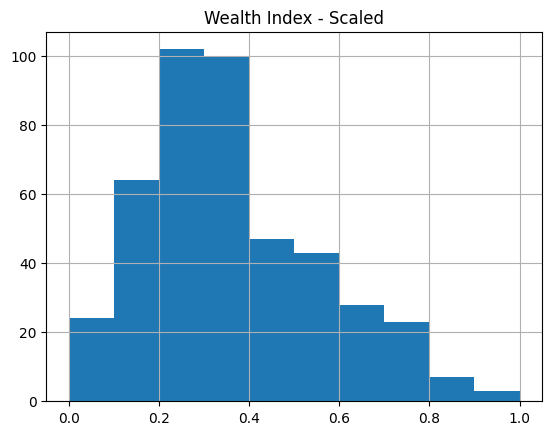

In [9]:
labels.hist()

# Save training data and column metadata

In [10]:
data_gdf = pd.concat([dhs_gdf, features, labels], axis=1)
data_gdf.to_csv(f"{ROLLOUT_DATE}-training-data.csv", index=False)

In [11]:
feature_cols = features.columns.tolist()
metadata_cols = [
    col for col in data_gdf if col not in feature_cols and col != OUTPUT_LABEL_COL
]

metadata = {
    "features": feature_cols,
    "label": OUTPUT_LABEL_COL,
    "metadata": metadata_cols,
}

filepath = f"{ROLLOUT_DATE}-training-data-columns.json"
with open(filepath, "w") as file:
    json.dump(metadata, file, indent=4)